# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

## looking at the big picture it seems a multiple univariate regression _ supervised learning 

# Get the data

In [2]:
train_set = pd.read_parquet('../input/kaggle-pog-series-s01e01/train.parquet')
test_set = pd.read_parquet('../input/kaggle-pog-series-s01e01/test.parquet')
submission = pd.read_csv('../input/kaggle-pog-series-s01e01/sample_submission.csv')

# Discover & visualize the Data to gain insights

In [3]:
train_set.shape, test_set.shape

((92275, 20), (5800, 16))

In [4]:
train_set.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,NaN,True,0.046804
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,NaN,True,0.040753


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92275 entries, 0 to 92274
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           92275 non-null  object             
 1   title              92275 non-null  object             
 2   publishedAt        92275 non-null  datetime64[ns, UTC]
 3   channelId          92275 non-null  object             
 4   channelTitle       92275 non-null  object             
 5   categoryId         92275 non-null  int64              
 6   trending_date      92275 non-null  object             
 7   tags               92275 non-null  object             
 8   view_count         92275 non-null  int64              
 9   likes              92275 non-null  int64              
 10  dislikes           92275 non-null  int64              
 11  comment_count      92275 non-null  int64              
 12  thumbnail_link     92275 non-null  object     

### Test data does not have categoryID 15 and 29.

In [6]:
train_set.describe()

,categoryId,view_count,likes,dislikes,comment_count,duration_seconds,target
count,92275.000000,9.227500e+04,9.227500e+04,92275.000000,9.227500e+04,90099.000000,92275.000000
mean,18.733416,2.779091e+06,1.521223e+05,3110.977307,1.373574e+04,760.614602,0.057060
std,6.866404,7.364113e+06,4.374777e+05,13342.743386,9.672682e+04,5816.818926,0.040373
min,1.000000,3.851000e+04,0.000000e+00,0.000000,0.000000e+00,3.000000,0.000000
25%,17.000000,5.312440e+05,2.136300e+04,368.000000,1.692000e+03,184.000000,0.028066
50%,20.000000,1.100045e+06,5.169200e+04,852.000000,3.856000e+03,446.000000,0.050784
75%,24.000000,2.482274e+06,1.312825e+05,2239.000000,9.322000e+03,854.000000,0.075265
max,29.000000,2.644074e+08,1.602153e+07,879354.000000,6.738537e+06,485620.000000,0.433503


# Fill Missing Values

In [7]:
#I notice that "description, duration_seconds" had missing values ..let's take care of this
train_set["description"].fillna('None', inplace=True)
test_set["description"].fillna('None', inplace=True)

In [8]:
#mean المتوسط
#mod القيمة الاكثر تكرارا
train_set['duration_seconds']=train_set['duration_seconds'].fillna(train_set['duration_seconds'].mean())
test_set['duration_seconds']=test_set['duration_seconds'].fillna(test_set['duration_seconds'].mean())

In [9]:
train_set.isnull().sum()

video_id             0
title                0
publishedAt          0
channelId            0
channelTitle         0
categoryId           0
trending_date        0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
id                   0
duration_seconds     0
has_thumbnail        0
target               0
dtype: int64

In [10]:
test_set.isnull().sum()

video_id             0
title                0
publishedAt          0
channelId            0
channelTitle         0
categoryId           0
trending_date        0
tags                 0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
id                   0
duration_seconds     0
has_thumbnail        0
isTest               0
dtype: int64

<AxesSubplot:>

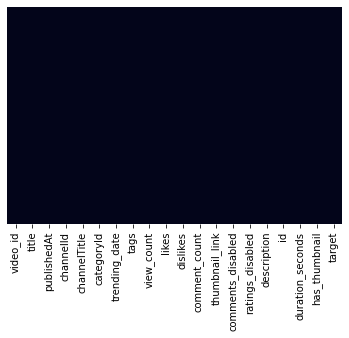

In [11]:
#HeatMap of Missing Values
sn.heatmap(train_set.isnull(),yticklabels=False,cbar=False)

# Correlations


In [12]:
#look for correlations
corr_matrix = train_set.corr()
corr_matrix["target"].sort_values(ascending=False)

target               1.000000
likes                0.203877
comment_count        0.081980
has_thumbnail        0.019487
dislikes             0.004226
view_count          -0.021704
duration_seconds    -0.035155
comments_disabled   -0.089399
categoryId          -0.096996
ratings_disabled    -0.098274
Name: target, dtype: float64

<AxesSubplot:>

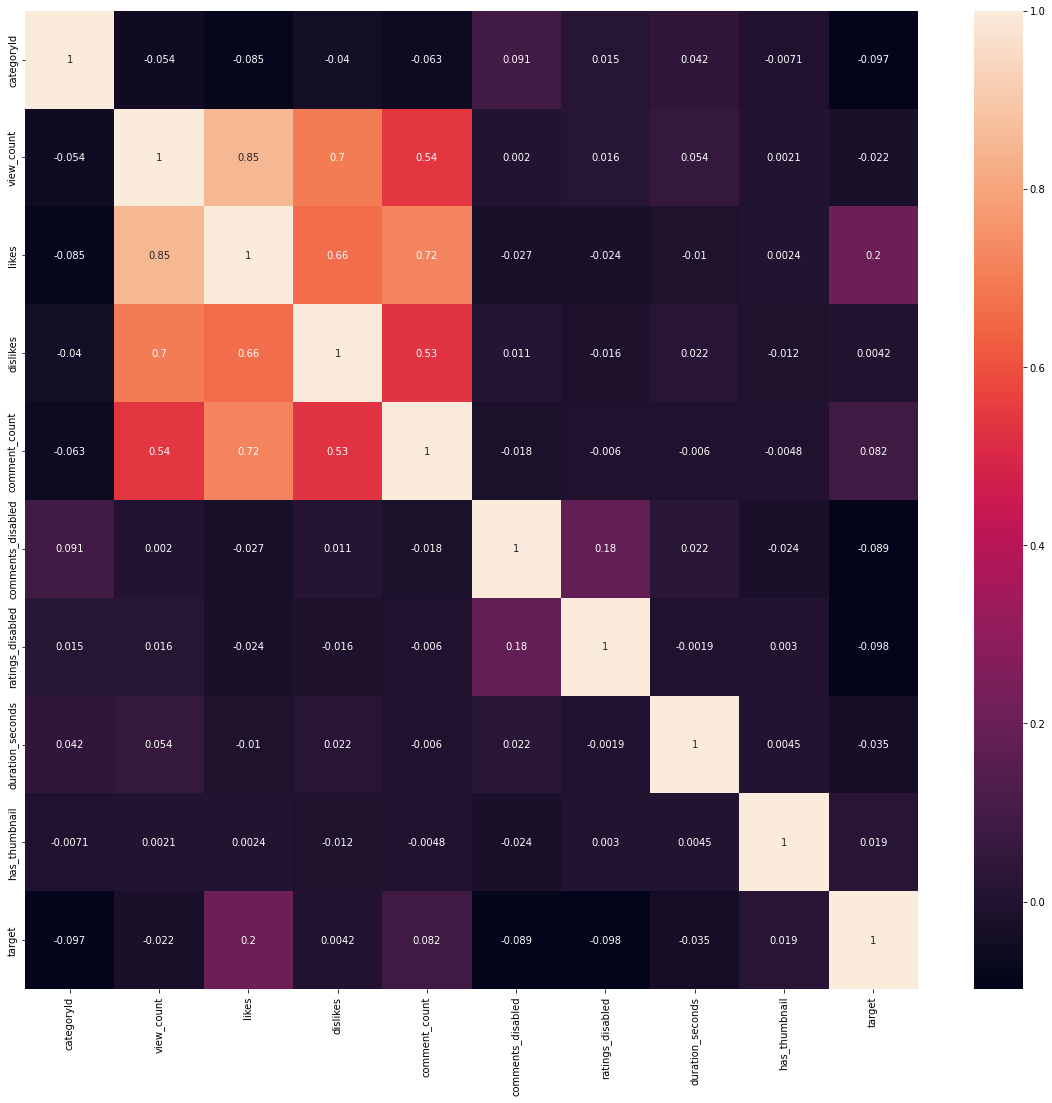

In [13]:
plt.figure(figsize = (20,18))
sn.heatmap(train_set.corr(), annot = True)

# WordCloud *Generate_from_frequencies* "ChannelTitle"

In [14]:
from collections import Counter

In [15]:
tokens = []
for i in train_set['channelTitle']:
    tokens.append(i)

In [16]:
#count the freq of each word
word_counts = Counter(tokens)

In [17]:
cloud = WordCloud(max_words = 200, colormap="Reds")
cloud.generate_from_frequencies(word_counts)

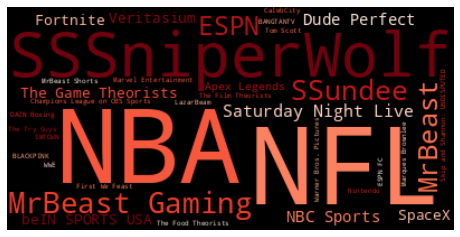

In [18]:
plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
#print(word_counts)

# KFold

In [20]:
cfg = {
    'TARGET' : 'target',
    'N_FOLDS' : 10,
    'RANDOM_STATE': 42,
    'N_ESTIMATORS' : 50_000,
    'LEARNING_RATE': 0.1
}

train_vids = train_set['video_id'].unique()
print(len(train_vids))
train_vids

16969


array(['3C66w5Z0ixs', 'M9Pmf9AB4Mo', 'J78aPJ3VyNs', ..., 'B5DWe7EWh1Y',
       'LgKVsV8593U', 'BtPqxeTT61Y'], dtype=object)

In [21]:
kf = KFold(n_splits=cfg['N_FOLDS'],
           shuffle=True,
           random_state=cfg['RANDOM_STATE'])

# Create Folds
fold = 1
for tr_idx, val_idx in kf.split(train_vids):
    fold_vids = train_vids[val_idx]
    train_set.loc[train_set['video_id'].isin(fold_vids), 'fold'] = fold
    fold += 1
train_set['fold'] = train_set['fold'].astype('int')
train_set.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target,fold
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,...,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,760.614602,True,0.103596,2
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,...,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,760.614602,True,0.061611,9
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,...,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,760.614602,True,0.173523,7
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,...,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,760.614602,True,0.046804,1
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,...,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,760.614602,True,0.040753,6


In [22]:
def create_features(df, train=True):
    """
    Adds features to training or test set.
    """
    df['publishedAt'] = pd.to_datetime(df['publishedAt'])
    df['trending_date'] = pd.to_datetime(df['trending_date'], utc=True)
    
    # Feature 1 - Age of video
    df['video_age_seconds'] = (df['trending_date'] - df['publishedAt']) \
        .dt.total_seconds().astype('int')
    
    # Trending day of week As a category
    df['trending_dow'] = df['trending_date'].dt.day_name()
    df['trending_dow']= df['trending_dow'].astype('category')
    
    df['published_dow'] = df['publishedAt'].dt.day_name()
    df['published_dow']= df['published_dow'].astype('category')
    
    df['categoryId'] = df['categoryId'].astype('category')
    
    df['channel_occurance'] = df['channelId'].map(
       df['channelId'].value_counts().to_dict())

    df['channel_unique_video_count'] = df['channelId'].map(
       df.groupby('channelId')['video_id'].nunique().to_dict())
    
    df['video_occurance_count'] = df.groupby('video_id')['trending_date'] \
       .rank().astype('int')
    
    return df

In [23]:
train_set['isTrain'] = True
test_set['isTrain'] = False
tt = pd.concat([train_set, test_set]).reset_index(drop=True).copy()
tt = create_features(tt)
train_feats = tt.query('isTrain').reset_index(drop=True).copy()
test_feats = tt.query('isTrain == False').reset_index(drop=True).copy()

In [24]:
train_feats.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,target,fold,isTrain,isTest,video_age_seconds,trending_dow,published_dow,channel_occurance,channel_unique_video_count,video_occurance_count
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614.0,156908.0,...,0.103596,2.0,True,NaN,16786,Wednesday,Tuesday,35,5,1
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688.0,146739.0,...,0.061611,9.0,True,NaN,25190,Wednesday,Tuesday,216,36,1
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853.0,353787.0,...,0.173523,7.0,True,NaN,26754,Wednesday,Tuesday,112,19,1
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771.0,23251.0,...,0.046804,1.0,True,NaN,26465,Wednesday,Tuesday,111,22,1
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889.0,45802.0,...,0.040753,6.0,True,NaN,31795,Wednesday,Tuesday,56,11,1


In [25]:
train_set.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target,fold,isTrain
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,...,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,760.614602,True,0.103596,2,True
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,...,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,760.614602,True,0.061611,9,True
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,...,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,760.614602,True,0.173523,7,True
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,...,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,760.614602,True,0.046804,1,True
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,...,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,760.614602,True,0.040753,6,True


In [26]:
FEATURES = ['video_age_seconds',
            'trending_dow',
            'published_dow',
            'categoryId',
            'duration_seconds',
            'comments_disabled',
            'ratings_disabled',
            'channel_occurance',
            'channel_unique_video_count',
            'video_occurance_count'
]

TARGET = ['target']

In [27]:
#code by https://www.kaggle.com/sandhyakrishnan02/pog-on-youtube-lgbm/notebook
X_test = test_feats[FEATURES]
oof = train_feats[['id','target', 'fold']].reset_index(drop=True).copy()
submission_df = test_set[['id']].copy()

In [28]:
oof.head()

,id,target,fold
0,3C66w5Z0ixs_2020-08-12,0.103596,2.0
1,M9Pmf9AB4Mo_2020-08-12,0.061611,9.0
2,J78aPJ3VyNs_2020-08-12,0.173523,7.0
3,kXLn3HkpjaA_2020-08-12,0.046804,1.0
4,VIUo6yapDbc_2020-08-12,0.040753,6.0


In [29]:
#code by https://www.kaggle.com/sandhyakrishnan02/pog-on-youtube-lgbm/notebook
regs = []

# Example Fold 1
for fold in range(1, 11):
    print(f'===== Running for fold {fold} =====')
    # Split train / val
    X_tr = train_feats.query('fold != @fold')[FEATURES]
    y_tr = train_feats.query('fold != @fold')[TARGET]
    X_val = train_feats.query('fold == @fold')[FEATURES]
    y_val = train_feats.query('fold == @fold')[TARGET]
    print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)

    # Create our model
    reg = lgb.LGBMRegressor(n_estimators=cfg['N_ESTIMATORS'],
                            learning_rate=cfg['LEARNING_RATE'],
                            objective='mae',
                            metric=['mae'],
                            importance_type='gain'
                           )
        # Fit our model
    reg.fit(X_tr, y_tr,
            eval_set=(X_val, y_val),
            early_stopping_rounds=500,
            verbose=200,
           )

    # Predicting on validation set
    fold_preds = reg.predict(X_val,
                             num_iteration=reg.best_iteration_)
    oof.loc[oof['fold'] == fold, 'preds'] = fold_preds
    # Score validation set
    fold_score = mean_absolute_error(
        oof.query('fold == 1')['target'],
            oof.query('fold == 1')['preds']
    )


    # Predicting on test
    fold_test_pred = reg.predict(X_test,
                num_iteration=reg.best_iteration_)
    submission_df[f'pred_{fold}'] = fold_test_pred
    print(f'Score of this fold is {fold_score:0.6f}')
    regs.append(reg)

===== Running for fold 1 =====
(83021, 10) (83021, 1) (9254, 10) (9254, 1)
[200]	valid_0's l1: 0.0188393
[400]	valid_0's l1: 0.018209
[600]	valid_0's l1: 0.0177176
[800]	valid_0's l1: 0.0175812
[1000]	valid_0's l1: 0.0175139
[1200]	valid_0's l1: 0.0174647
[1400]	valid_0's l1: 0.0174344
[1600]	valid_0's l1: 0.0173217
[1800]	valid_0's l1: 0.0173224
[2000]	valid_0's l1: 0.0173297
Score of this fold is 0.017279
===== Running for fold 2 =====
(83017, 10) (83017, 1) (9258, 10) (9258, 1)
[200]	valid_0's l1: 0.0191249
[400]	valid_0's l1: 0.0186178
[600]	valid_0's l1: 0.018347
[800]	valid_0's l1: 0.0180243
[1000]	valid_0's l1: 0.0179454
[1200]	valid_0's l1: 0.0178626
[1400]	valid_0's l1: 0.0177301
[1600]	valid_0's l1: 0.0177529
[1800]	valid_0's l1: 0.0177587
Score of this fold is 0.017279
===== Running for fold 3 =====
(83059, 10) (83059, 1) (9216, 10) (9216, 1)
[200]	valid_0's l1: 0.0204356
[400]	valid_0's l1: 0.0197896
[600]	valid_0's l1: 0.0194864
[800]	valid_0's l1: 0.0192502
[1000]	valid_0

# Creat Submission

In [30]:
pred_cols = [c for c in submission_df.columns if c.startswith('pred_')]

submission_df['target'] = submission_df[pred_cols].mean(axis=1)

In [31]:
submission_df[['id','target']] \
.to_csv('submission.csv', index=False)